In [142]:
import pandas as pd
import numpy as np
import pytraj as pyt
import glob, os, sys
import pickle
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')

In [2]:
prot_name = 'cdk2'

In [3]:
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
path_to_json_file = glob.glob((os.path.join('..', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO_LABELS.json')))[0]
                      
df_prot = pd.read_json(path_to_json_file)

In [4]:
from modules.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",")
pocket_residues = get_pocket_residues(sep=",")

In [5]:
mask_pisani = F"(:{pisiani_residues})&(@CA)"

In [6]:
# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = os.path.join("..", "..", "ARCHIVOS", "CRISTALES", 
                                  "TRAJ_CRISTALS_PDB", "PDB_402_cdk2_PISANI_ALL.pdb")
# Por ahora cargamos tods los átomos, sumiendo que en algun momento necesitaremos todos los átomos
traj_crystals = pyt.load(file_pdb_traj_pisani)
# Nos aseguramos de superponer la trayectoria a una estructura promedio
# NOTA: prody realiza esta optimización iterando hasta minimizar el rmsd con el método superpose
# no obstante, las pruebas hechas muestran que el impacto es mínimo 
# pues incluso omitiendo las siguientes tres líneas el mds es el msimo
traj_crystals = traj_crystals.superpose()[mask_pisani]
avg_ref_traj = pyt.mean_structure(traj_crystals)
pyt.superpose(traj_crystals, ref = avg_ref_traj)

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 402.
Número de átomos: 117.


In [7]:
# Obtenemos el MDS usando la subsecuencia de pisani y las 402 estructuras
rmsd_402_crys = pyt.pairwise_rmsd(traj = traj_crystals, metric="rms")

In [8]:
from modules.MDS import cMDS, cMDS_proj
# Llevamos a cabo el mds
mds_total = cMDS(rmsd_402_crys)

In [9]:
from miscellanious_traj_functions import process_pca, get_sup_points_projected_mds

In [10]:
DM_DIR =  os.path.join('..', '..', 'ARCHIVOS', 'DINAMICA')

In [57]:
def process_md_traj():
    pass

In [105]:
def process_trajectories_rep(system, md_type, file_basename, mask, 
                       ref_obj_mds, traj_reference,
                       prod_dir = '4_prod', system_dir = DM_DIR):
    # OJO: La máscara debe ser aplicada una sola vez

    # Carga de la estructura inicial, se extrae por default de la rep_1
    sytem_path = os.path.join(system_dir, system, md_type)
    ref_rst7 = os.path.join(sytem_path, 'rep_1', F'{file_basename}.rst7')
    ref_prmtop = os.path.join(sytem_path, 'rep_1', F'{file_basename}.prmtop')
    ref_conf = pyt.load(filename = ref_rst7, top = ref_prmtop)
    # Seleccionamos únicamente la proteína
    ref_conf = ref_conf[mask]
    
    # Generamos el path de las conformaciones
    # Cargamos todas las trayectorias en  orden alfanumérico
    prmtop_files = sorted(glob.glob(os.path.join(sytem_path, 
                                             'rep_*', prod_dir, 'CA*prmtop')))
    nc_files = sorted(glob.glob(os.path.join(sytem_path, 
                                             'rep_*', prod_dir, 'CA*_prod.nc')))
    
    # Lista de trayectorias
    traj_list = [pyt.iterload(traj_file, prmtop_files[0],
                             frame_slice=(0, 1000)
                             ) for traj_file in nc_files]
    # En este punto a las trayectorias no se le han aplicado la máscara
    
    # Diccionario de trayectorias
    # Todas son superpuestas a la conformación inicial, y se aplica la máscara
    dic_trajs = {F'rep_{i+1}': 
                 traj_list[i][mask].superpose(ref = ref_conf)
                 for i in range (len(traj_list))}
    #print(dic_trajs)
    
    # Cálculo del Rmsd por replica, almacenado en un dataFrame
    pd_rmsd = pd.DataFrame({key: pyt.rmsd(traj, 
                    ref = ref_conf) 
                    for key, traj in dic_trajs.items()})
    
    # Se obtienen los PCA independientes (por replica) usando sklearn
    # Los pca independientes no tienen superposición con el frame inicial
#     dic_pca_traj = {key: process_pca(traj, ref = 0, n_vecs = 2) 
#                     for key, traj in dic_trajs.items()}
    
    # MDS: proyecciones en el espacio de referencia de cristales
    dic_mds_proj_traj = {key: get_sup_points_projected_mds(
                                          MDS_ref_object = ref_obj_mds,
                                          traj_reference = traj_reference,
                                          traj_out_of_sample = traj_proj,
                                          ref = 0, n_components = 2) 
                         for key, traj_proj in dic_trajs.items()}
    
    return(dic_mds_proj_traj)

In [106]:
d_4fku_sa_dm = process_trajectories_rep(system = '4fku', md_type = 'sa_dm', 
                   file_basename = 'cdk2', mask = mask_pisani,
                   ref_obj_mds = mds_total, traj_reference = traj_crystals)

In [107]:
d_4fku_mx_sa = process_trajectories_rep(system = '4fku', md_type = 'mxs_sa', 
                   file_basename = 'mxs_cdk2', mask = mask_pisani,
                   ref_obj_mds = mds_total, traj_reference = traj_crystals)

In [108]:
d_4fku_mix_solv = process_trajectories_rep(system = '4fku', md_type = 'mix_solv', 
                   file_basename = 'mxs_cdk2', mask = mask_pisani,
                   ref_obj_mds = mds_total, traj_reference = traj_crystals)

In [127]:
d_4fku_lig_cs262 = process_trajectories_rep(system = '4fku', md_type = 'sa_lig_CS262', 
                   file_basename = 'cdk2_LIG', mask = mask_pisani,
                   ref_obj_mds = mds_total, traj_reference = traj_crystals)

In [110]:
d_1fin_sa_dm = process_trajectories_rep(system = '1fin', md_type = 'sa_dm', 
                   file_basename = 'sa_dm_1fin', mask = mask_pisani,
                   ref_obj_mds = mds_total, traj_reference = traj_crystals)

In [114]:
d_1fin_mx_sa = process_trajectories_rep(system = '1fin', md_type = 'mxs_sa', 
                   file_basename = 'mxs_1fin', mask = mask_pisani,
                   ref_obj_mds = mds_total, traj_reference = traj_crystals)

In [116]:
d_1fin_lig_atp = process_trajectories_rep(system = '1fin', md_type = 'sa_lig_ATP', 
                   file_basename = 'sa_lig_1fin_ATP', mask = mask_pisani,
                   ref_obj_mds = mds_total, traj_reference = traj_crystals)

In [118]:
d_1fin_lig_cs262 = process_trajectories_rep(system = '1fin', md_type = 'sa_lig_CS262', 
                   file_basename = 'sa_lig_1fin_CS262', mask = mask_pisani,
                   ref_obj_mds = mds_total, traj_reference = traj_crystals)

In [139]:
# guardamos los diccionarios
dic_mds_all_dinamicas = {'cdk2': {
                            '4fku': {
                                 'sa_dm':  d_4fku_sa_dm,
                                 'mxs_dm': d_4fku_mix_solv,
                                 'mxs_sa': d_4fku_mx_sa,
                                 'mxs_lig_CS262': d_4fku_lig_CS262,
                                },

                            '1fin': {
                                 'sa_dm':  d_1fin_sa_dm,
                                 'mxs_dm': None,
                                 'mxs_sa': d_1fin_mx_sa,
                                 'mxs_lig_ATP': d_1fin_lig_cs262,
                                 'mxs_lig_CS262': d_1fin_lig_cs262,
                                }
                            }
                        }

In [141]:
import pickle
with open('../data/trajectory_analysis/mds_all_traj_projections.obj', 'wb') as fp:
    pickle.dump(dic_mds_all_dinamicas, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

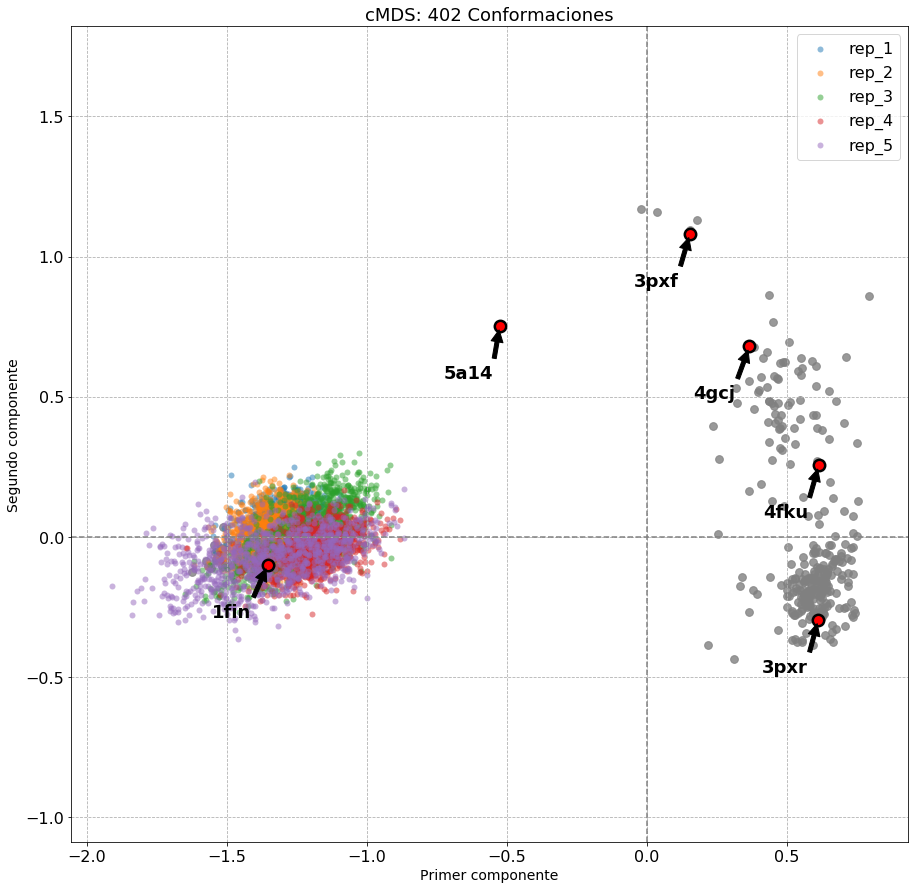

In [119]:
# Prueba de get_sup_rmsd_pairwise con los cristales
from modules.MDS import cMDS_proj
from modules.plotting_functions import plot_points, plot_anotation_labels

ref_structs_dict = {"1fin": "red", "5a14": "cyan", "4fku": "black",
                    "3pxr": "green", "4gcj": "blue", "3pxf": "orange"}
# Se genera la gráfica
fig = plt.figure(figsize=(15, 15))
plot_points(mds = mds_total[0], alpha=0.8, colors_list= ['grey'],
                             title = "cMDS: 402 Conformaciones")
# Plotting the projection
for key, proj_mds in d_1fin_lig_cs262.items():
    sns.scatterplot(x = proj_mds[0], y = proj_mds[1], label = key, linewidth = 0, alpha = 0.5)
# for key, proj_mds in d_4fku_mx_sa.items():
#     sns.scatterplot(x = proj_mds[0], y = proj_mds[1], label = key, linewidth = 0, alpha = 0.5)
# for key, proj_mds in d_4fku_mix_solv.items():
#     sns.scatterplot(x = proj_mds[0], y = proj_mds[1], label = key, linewidth = 0, alpha = 0.5)
# for key, proj_mds in d_4fku_lig_CS262.items():
#     sns.scatterplot(x = proj_mds[0], y = proj_mds[1], label = key, linewidth = 0, alpha = 0.5)
# proj_mds = d_4fku_sa_dm['rep_5']
# sns.scatterplot(x = proj_mds[0], y = proj_mds[1], label = key, linewidth = 0, alpha = 0.5)

plot_anotation_labels(df_prot.index,  ref_structs_dict.keys(), 
                      mds_total[0][0], mds_total[0][1], 
                      xytext_delta=[0.2, 0.2], s=130, c= 'red')